In [141]:
import CodaPCA
import CodaRegressmb as CodaRegress
import numpy as np
from runpca import read_csv
import os
import sklearn
import torch
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
#change module for newer sklearn versions
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
import matplotlib.pyplot as plt
import pandas as pd
import PCARegress
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

import importlib
importlib.reload(CodaRegress)

<module 'CodaRegressmb' from 'C:\\Users\\u5801283\\Documents\\Honours\\honours_final\\honours\\Code\\coda-pca-orig\\coda\\codes\\CodaRegressmb.py'>

In [142]:
def coda_val(features, targets, n_components, folds):
    targets = targets.reshape(-1,1)
    param_splits = 2
    kfold_scores = []
    for train, test in folds:        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        
        kf_inner = KFold(param_splits)
        
        inner_folds = [i for i in kf_inner.split(X_train)]      
            
        #inner loop for parameter selection (lambda term in combined loss):
        param_grid = [5e-12]#[1e-16,1e-12,1e-10, 1e-8, 1e-6,1e-3,1,10]
        
#         max_error = np.inf
#         for a in param_grid:
            
#             cval_error = []
#             #find the parameter which obtains the best inner cross val score
#             for train_inner, test_inner in inner_folds:
                
#                 model = CodaRegress.CoDA_Regress(features.shape[1], n_components, [100,], [20,])
                
                
#                 model.fit(torch.FloatTensor(X_train[train_inner]),  torch.FloatTensor(Y_train[train_inner]), a, lr=1e-3, train_size = len(X_train[train_inner]))

#                 y_inner_pred = model.predict(torch.FloatTensor(X_train[test_inner]))
    
#                 cval_error.append(sklearn.metrics.mean_squared_error(Y_train[test_inner],y_inner_pred.detach().numpy()))
        

#             curr_error = np.mean(cval_error)
#             if curr_error < max_error:
#                 max_error = curr_error
#                 best_param = a
#                 print ("Current best", best_param)
        
        #compute test score based on best parameter
        best_model = CodaRegress.CoDA_Regress(features.shape[1], n_components, [5,], [3,])
        val_arr, train_arr = best_model.fit(torch.FloatTensor(X_train),  torch.FloatTensor(Y_train), 1e-10, lr=1e-3, train_size = int(len(X_train)*(3/4)), epochs=3000)
    
        print ("Plot!")
        
        plt.plot(val_arr, c="red")
        plt.plot(train_arr, c="blue")
        
        #plt.ylim(top=-min(train_arr))
        plt.ylim(bottom=min(train_arr))

        plt.show()
        y_pred = best_model.predict(torch.FloatTensor(X_test))
        kfold_scores.append(sklearn.metrics.mean_squared_error(Y_test,y_pred.detach().numpy()))
                
    return kfold_scores

    
    
    

In [143]:

#need to specify where the the targets and features are in the dataset, and whether there are non compositional features

def PCA_Regression(data, co_feature_indices, target_index, 
                   other_feature_indices = [], alg=CodaPCA.Alg.CODAPCA, verbose=True):
    
    #can loop through/optimise this in another way?
    
    headers = data
    features = data[:,co_feature_indices]
    targets = data[:,target_index]
    
    #normalise the compositional features. TODO anything extra to deal with non compositional features?
    #features = np.array([feat/sum(feat) for feat in features])

    #can be empty
    #extra_features = data[0][:,other_feature_indices]
    
    #TODO double check this
    #features = np.hstack([features, extra_features])
    
    #compute the CoDA-PCA projection 
    #TODO add component number as a hyperparameter to optimise 
    n_components=2
    
    #len(co_feature_indices)-2

    pca = CodaPCA.CodaPCA(n_components,lrate=1e-4,nn_shape=[100,100], alg=alg)
    #pca = CodaPCA.NonParametricCodaPCA(n_components)

    pca.fit(features)
    
    Y_coda = pca.transform(features)

    pca_clr = CodaPCA.CLRPCA(n_components)
    pca_clr.fit(features)
    
    Y_clr = pca_clr.transform(features)
    
    splits = 4
        
    #split data 
    kf = KFold(splits)
        
    folds = [i for i in kf.split(features)]      
    

    lm = Ridge()
    
    sc = StandardScaler()
    features_ = sc.fit_transform(np.array(features, dtype=np.float32))

    pca_reg = decomposition.PCA(n_components)

    pca_reg.fit(features_)
    Y_pca = pca_reg.transform(features_)
    
    
    coda_score = enhanced_cross_val(lm,Y_coda, targets, folds)
    clr_score = enhanced_cross_val(lm,Y_clr, targets, folds) 
    naive_score = enhanced_cross_val(lm, features, targets, folds)
    
    regress_score = coda_val(features, targets, n_components, folds)
    


    if verbose:
        print("CoDA-PCA:")
        print(coda_score)
        print("CLR-PCA:")
        print(clr_score)
        print ("Naive regression:")
        print (naive_score)
        print ("CoDA-Regress:")
        print (regress_score)
    

    return coda_score,clr_score,naive_score,regress_score

#training methodology as described in:
#https://papers.nips.cc/paper/3215-learning-with-transformation-invariant-kernels.pdf
def enhanced_cross_val(model, features, targets, folds):
    assert len(features) == len(targets), "Mismatch in length of features and targets"
    
    #define the number of splits and folds uised in the parameter selection
    #stick to smaller splits since we have small datasets
    #splits = 4
    param_splits = 3
    #split data 
    #kf = KFold(splits)
    kfold_scores = []
    
    for train, test in folds:        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        #inner loop for parameter selection (regularisation term in Ridge Regression):
        param_grid = [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0]
        max_score = -np.inf
        for a in param_grid:
            lm = Ridge(a)
   
            curr_score = np.mean(cross_val_score(lm, X_train, Y_train,cv=param_splits))
            if curr_score > max_score:
                max_score = curr_score
                best_param = a
                
        
        #compute test score based on best parameter
        lm = Ridge(best_param)
        lm.fit(X_train, Y_train)
        y_pred = lm.predict(X_test)
        kfold_scores.append(sklearn.metrics.mean_squared_error(Y_test,y_pred))
                
    return kfold_scores




In [4]:
n = 1000

x_1 = np.ceil(np.linspace(0,10,n) + 2*np.random.rand(n))
x_2 = np.ceil(np.clip(0, np.linspace(0,10,n) - 3*np.random.rand(n), 10)[::-1])
x_3 = np.ceil(5* np.ones(n) + 5*np.random.rand(n))

X = np.vstack([x_1, x_2, x_3])
X = [[X[0][i], X[1][i], X[2][i]] for i in range(0,X.shape[1])]
X = np.array([feat/sum(feat) for feat in X])
Y = np.linspace(0,50, n) + 5*np.random.rand(n)
Y = Y.reshape(-1,1)
data = np.hstack((X,Y))
data

array([[5.00000000e-02, 5.00000000e-01, 4.50000000e-01, 2.90477660e+00],
       [1.00000000e-01, 5.00000000e-01, 4.00000000e-01, 1.81096293e+00],
       [9.52380952e-02, 4.76190476e-01, 4.28571429e-01, 4.28667342e+00],
       ...,
       [5.45454545e-01, 0.00000000e+00, 4.54545455e-01, 5.33021515e+01],
       [5.45454545e-01, 0.00000000e+00, 4.54545455e-01, 5.43482905e+01],
       [5.78947368e-01, 0.00000000e+00, 4.21052632e-01, 5.12905792e+01]])

[epoch     0] L=  0.1560
loading
Plot!


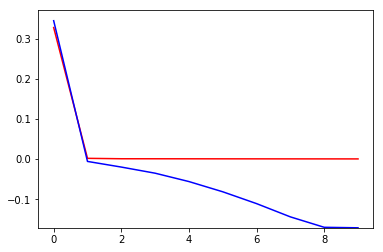

loading
Plot!


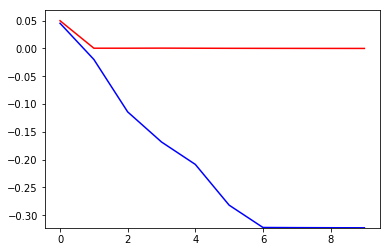

loading
Plot!


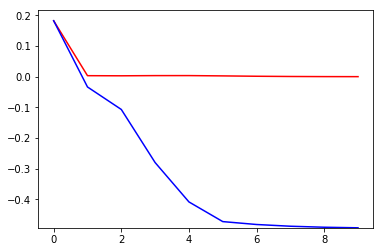

loading
Plot!


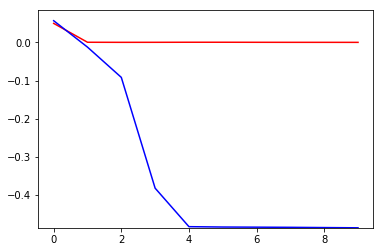

CoDA-PCA:
[0.000273406266623206, 6.343691229201589e-05, 5.1599590104695474e-05, 7.169297136686303e-05]
CLR-PCA:
[0.0007203269511067524, 8.898667452737123e-05, 6.975909904918162e-05, 9.301556764004817e-05]
Naive regression:
[1.5795588593599943e-07, 1.4814311191245042e-07, 1.321803299084634e-07, 2.0417199236657106e-07]
CoDA-Regress:
[0.32629572667428774, 0.04987491442833411, 0.1824633709843415, 0.0516640917789172]


In [67]:
%matplotlib inline

synth_scores = PCA_Regression(data, co_feature_indices=[0,1,2], target_index=3)

In [6]:
[np.mean(synth_scores[i]) for i in range(0,4)]

[101.27271085717597, 181.84989623592037, 14.885074088442, 237.07374333643043]

In [7]:
#[156.86020353376762, 135.17164010434274, 14.574787535366715, 61.24176619391193]

In [3]:
#generate arms dataset (from CodaPCA original source)
def arms( dim, M=100 ):
    '''
    toy dataset on the simplex

    dim arms
    each arm has M samples
    '''
    print( 'generating {}arms dataset...'.format( dim ) )
    O = np.ones( dim ) / dim

    X = []
    for i in range( dim ):
        P = np.ones( dim ) * 1e-4
        P[i] = 1
        P /= P.sum()

        X += [ ( (1-lam) * O + lam * P ) for lam in np.linspace(0,1,M) ]

    X = np.array( X )
    print( '{0} samples {1} features'.format( X.shape[0], X.shape[1] ) )
    return X

X = np.array(arms(20))

generating 20arms dataset...
2000 samples 20 features


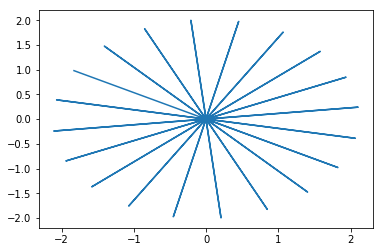

In [6]:
pca = CodaPCA.NonParametricCodaPCA(2)#,lrate=1e-3,nn_shape=[50,10], alg=CodaPCA.Alg.CODAAE)
    #TODO: check why this is numerically unstable
    #pca = CodaPCA.NonParametricCodaPCA(n_components)
    

Y_coda = pca.fit_transform(X)
%matplotlib inline
plt.plot(Y_coda[:,0], Y_coda[:,1])

plt.show()

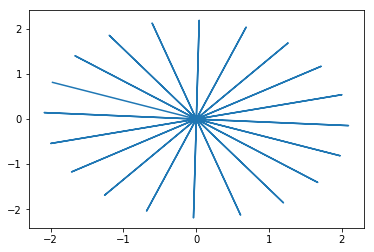

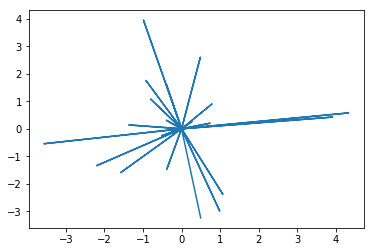

In [12]:


sc = StandardScaler()
X = sc.fit_transform(X)

    
pca_reg = decomposition.PCA(2)
    
Y_pca = pca_reg.fit_transform(X)
    
%matplotlib inline
plt.plot(Y_pca[:,0], Y_pca[:,1])

plt.show()


In [11]:
Y = np.array([max(X[i]) for i in range(0,len(X))])
Y = Y.reshape(-1,1)

data = np.hstack((X,Y))

In [32]:
synth_scores = PCA_Regression(data, co_feature_indices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], target_index=20)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [13]:
[np.mean(synth_scores[i]) for i in range(0,4)]

[0.07812749974963772,
 0.07962319145704255,
 0.08776808541197213,
 0.7545410077469336]

In [14]:
[np.mean(synth_scores[i]) for i in range(0,4)]

[0.07812749974963772,
 0.07962319145704255,
 0.08776808541197213,
 0.7545410077469336]

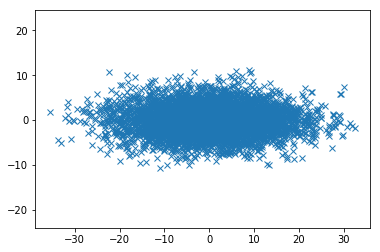

In [147]:
%matplotlib inline
mean = [0, 0]
cov = [[100, 0], [0, 10]]  # diagonal covariance

x, y= np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

#3d case
mean = [0, 0, 0, 0,0,0,0]
vs = [5000,1000,500,100,10,1,0.1]
cov = np.diag(vs)

X = np.random.multivariate_normal(mean, cov, 10000)
#scale to make everything positive
for i in range(0,X.shape[1]):
    X[:,i] = X[:,i] + np.abs(min(X[:,i]))







targ = X[:,-1]**3 + X[:,-1] - 3



#data = np.add(data,abs(np.min(data)))
#data = np.array([feat/sum(feat) for feat in X])


#make target a function of third vector
data = np.hstack((data, targ.reshape(-1,1)))

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.axis('equal')

# ax.scatter(xs = data[:,0], ys = data[:,1], zs = data[:,2])

# ax.view_init(180, 45)
# plt.draw()


In [121]:
print (X[:,1])

[108.8243629  132.16318196 132.31623765 ... 102.37997139 109.6582027
  71.59079233]


In [28]:
min(z)

0.0

In [15]:
min(data[2])

-3.506960840294891

In [51]:
os.getcwd()

'C:\\Users\\u5801283\\Documents\\Honours\\honours_final\\honours\\Code\\coda-pca-orig\\coda\\codes'

[epoch     0] L=-11.9958
epoch 1000, loss 1.1293294429779053
epoch 2000, loss 0.958816647529602
loading
Plot!


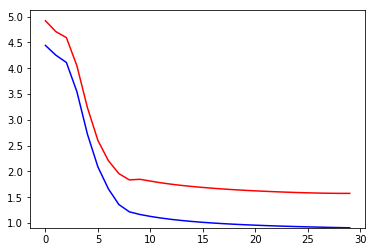

epoch 1000, loss 0.7052566409111023
epoch 2000, loss 0.5410395264625549
loading
Plot!


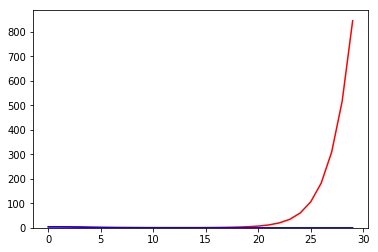

epoch 1000, loss 4.019242763519287
epoch 2000, loss 1.8857793807983398
loading
Plot!


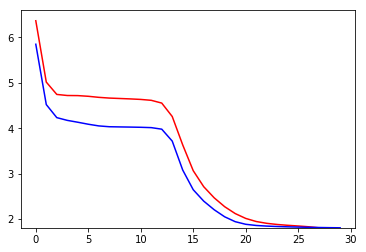

epoch 1000, loss 1.0612818002700806
epoch 2000, loss 0.8704771995544434
loading
Plot!


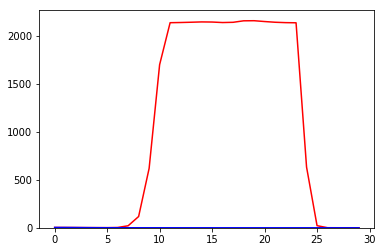

CoDA-PCA:
[4.05062805609367, 4.0125053852845305, 4.072322483512422, 4.305914471401059]
CLR-PCA:
[4.309307711506608, 4.1866565623069345, 4.3859931498965175, 4.499197143127055]
Naive regression:
[2.731511687224471, 2.6388626552281385, 2.7570605531999437, 2.8814106289304275]
CoDA-Regress:
[3.0905659490788904, 1.3749063731167974, 1.732189158133324, 1.2153708248717427]


In [148]:
importlib.reload(CodaRegress)
synth_scores = PCA_Regression(data, co_feature_indices=[0,1,2,3,4,5,6], target_index=7)